In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/113169375.gadi-pbs'

In [ ]:


FilePath='/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl/' # Truth file settings
prefix='roms_his_'
timeRange = [12, 13]
datelist = np.array(range(timeRange[0],timeRange[1],1))

def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')



['/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl/roms_his_0012.nc']


In [ ]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v12_grd.nc')

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r


In [ ]:
# load single ROMS netcdf with xr
# ds = xr.open_dataset('../data/proc/roms_v11_TotOptions_his_0003_5daymn.nc')
ds = xr.open_dataset('../data/proc/roms_v11_ctrl_his_0011-13_5daymn.nc')
ds

In [ ]:
ds = ds.drop_vars(['Tb','Sb','u_eastward','v_northward','ubar_eastward','vbar_northward','w','shflux','ssflux','sustr','svstr','m','zeta','rho','angle','f'])
print(ds.nbytes/1e9,'G')
ds

In [ ]:
ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

ds['hc'] = grd.hc
ds['s_w']=grd.s_w
ds['s_rho']=grd.s_rho
ds['Cs_w']=grd.Cs_w
ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice
ds['mask_zice_nan'] = (ds.mask_rho.where(ds.zice<0)==1).where(ds.mask_rho.where(ds.zice<0)==1) # make a mask where non-ice is nan

In [ ]:
# make masks

# now make a ROI mask(s)
# plt.figure(figsize=(6,4))
# ds.mask_zice.plot(x='x_rho',y='y_rho')
# plt.grid()
poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

In [ ]:
weights = (1/ds.pm)*(1/ds.pn)
weights.name = "weights"

In [ ]:
# ds.load()

In [ ]:
# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))



In [12]:
# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid


ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

In [13]:
# min_eta=363
# fig,axes=plt.subplots(nrows=2,figsize=(8,5),sharex=True)
# ax=axes[0]
# im=(ds.temp).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').isel(eta_rho=min_eta).plot(ax=ax,x='x_rho',y='z_rho0',cmap='cmo.thermal',vmin=-2.4,vmax=-.5)
# ax.set_xlim((1.7e6,2.47e6))
# ax.set_ylim((-2800,-10))
# ax.set_xlabel('')
# ax.grid()

# ax=axes[1]
# im=(ds.temp).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').isel(eta_rho=min_eta).plot(ax=ax,x='x_rho',y='z_rho0',cmap='cmo.thermal',vmin=-2.4,vmax=-.5)
# ax.set_xlim((1.7e6,2.47e6))
# ax.set_ylim((-2800,-10))
# ax.grid()
# ax.set_xlabel('Eastings (m PSG-71)')
# plt.show()

# # im=(ds.temp).isel(ocean_time=slice(5,18)).isel(s_rho=-1).mean(dim='ocean_time').plot(cmap='cmo.thermal',vmin=-2.5,vmax=.5)
# # (ds.zice*ds.mask_rho).plot.contour(levels=[-1,0],colors='C1',linewidths=1)

# # plt.axhline(y=min_eta)
# # plt.plot(min_xi,min_eta,'x')
# # plt.show()

In [14]:
# # make 400m transects
# target_depth = -400

# target_time = slice(5,18)
# temp400_FM = grid.transform(ds.temp.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_FM = grid.transform(ds.salt.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # ur400_FM = grid.transform(ds.u_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # vr400_FM = grid.transform(ds.v_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()




# target_time = slice(55,67)
# temp400_ON = grid.transform(ds.temp.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_ON = grid.transform(ds.salt.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # ur400_ON = grid.transform(ds.u_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# # vr400_ON = grid.transform(ds.v_rho.isel(ocean_time=target_time).mean(dim='ocean_time'), 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()


In [15]:
import seawater as sw
sw.temp(35,-2,1000)

-1.9715341195598077

In [16]:
aa=-5.73e-2
bb=9.39e-2
cc=-7.61e-4


Tb_FM = ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
Sb_FM = ds.salt.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')

Tf = aa*Sb_FM + bb + cc*-ds.zice


Tb_insitu = sw.temp(Sb_FM,Tb_FM,-ds.z_rho0.isel(s_rho=-1).values)

Tstar = (Tb_insitu-Tf)*ds.mask_zice_nan


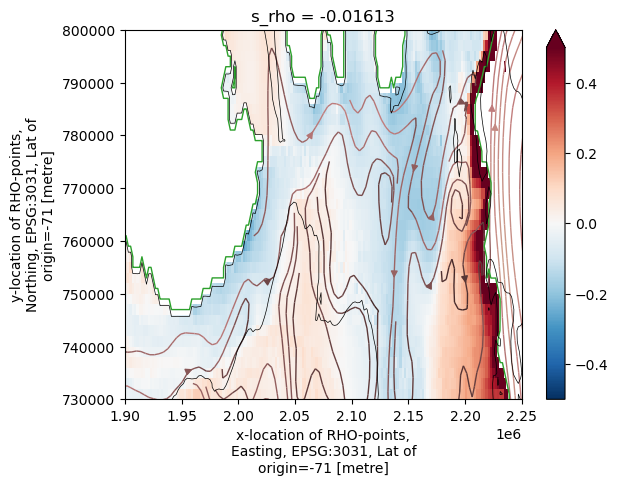

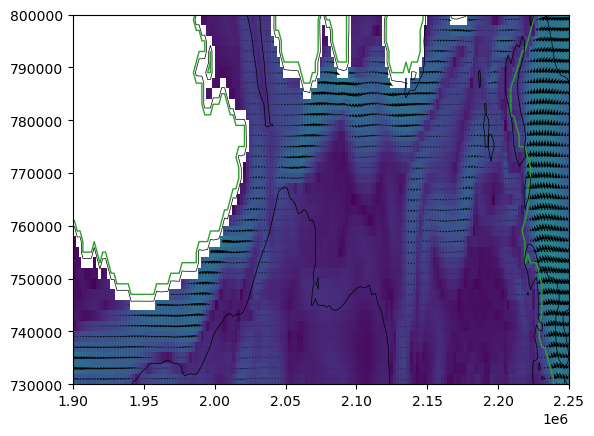

In [17]:
uvel=ds.u_rho.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vvel=ds.v_rho.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
str_kwargs = {"color":vel_mag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":15,
              "cmap":"pink"}
ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-1.5,levels=12)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.25e6))
plt.ylim((.73e6,.8e6))
plt.show()

Tstar.plot.pcolormesh(x='x_rho',y='y_rho',cmap='RdBu_r',vmin=-.5,vmax=.5)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.25e6))
plt.ylim((.73e6,.8e6))

plt.show()

st = plt.pcolormesh(ds.x_rho.values, ds.y_rho.values, vel_mag,)
st = plt.quiver(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,scale=15,minshaft = 1, minlength=0)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.25e6))
plt.ylim((.73e6,.8e6))

plt.show()


# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# temp400_ON.plot.contourf(x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-.5,levels=12)
# st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
# co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
# plt.xlim((2.2e6,2.47e6))
# plt.ylim((.4e6,1.0e6))

Text(0.5, 1.0, '')

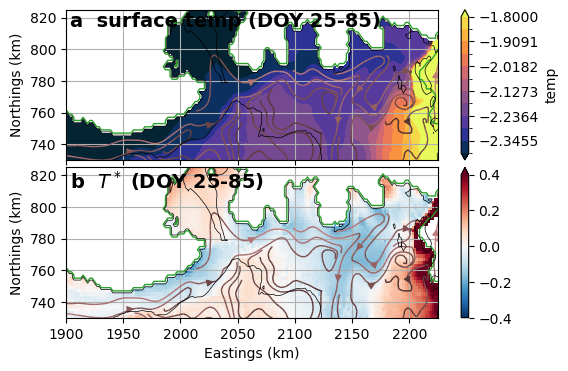

In [18]:

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(6,4))

ax=fig.add_subplot(gs[0,0])
ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-1.8,levels=12)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.225e6))
plt.ylim((.73e6,.825e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'a  surface temp (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('')

ax=fig.add_subplot(gs[1,0])
Tstar.plot.pcolormesh(ax=ax,x='x_rho',y='y_rho',cmap='RdBu_r',vmin=-.4,vmax=.4)
st = plt.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = plt.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = plt.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.xlim((1.9e6,2.225e6))
plt.ylim((.73e6,.825e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
ax.text(0.01, 0.99, 'b  $T^*$ (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
ax.set_title('')



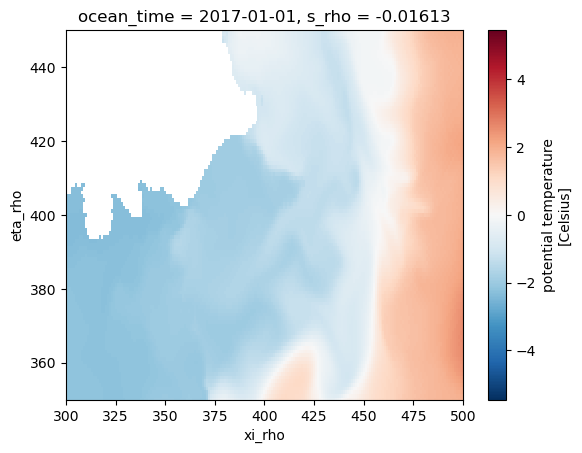

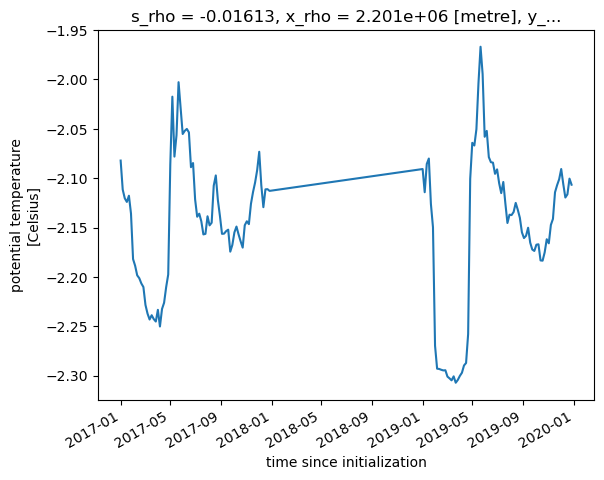

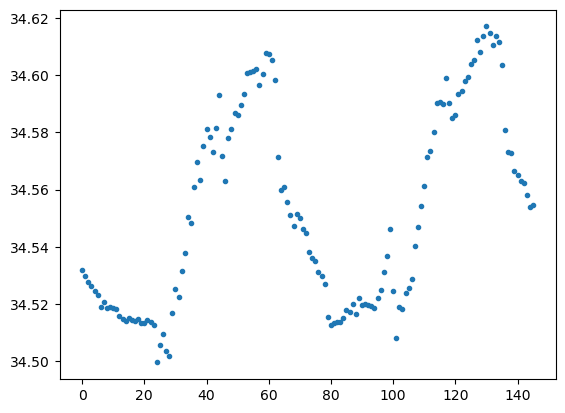

In [19]:
ds.temp.isel(s_rho=-1,ocean_time=0).plot()
plt.axis((300,500,350,450))
plt.show()
ds.temp.isel(s_rho=-1,eta_rho=395,xi_rho=350).plot()
plt.show()
plt.plot(ds.salt.isel(s_rho=-1,eta_rho=395,xi_rho=350),'.')


In [20]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5

str_kwargs = {"color":vel_mag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":5,
              "cmap":"pink"}


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(6,8))
ax=fig.add_subplot(gs[0,1])
ds.temp.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
# ax.set_xlabel('')
ax.text(0.01, 0.99, 'c  surface temp\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
ax.set_title('')



In [ ]:


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,8])
ax = None

ax=fig.add_subplot(gs[0,0])
#change to 400m
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))

ax=fig.add_subplot(gs[1,0])
#change to 400m
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))


ax=fig.add_subplot(gs[0,1])
#change to 400m
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))

ax=fig.add_subplot(gs[1,1])
#change to 400m
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))





In [ ]:


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,8])
ax = None



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,0])
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'a  400m\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_ylabel('Northings (km)')
ax.set_xticklabels([])
ax.set_title('')


# convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

arr_start_ps=(1.75e6,.625e6)
arr_start = ps_to_ll.transform(arr_start_ps[0],arr_start_ps[1])
print(arr_start_ps)
arr_end = ll_to_ps.transform(arr_start[0]+0.5,arr_start[1])
print(arr_end)
ax.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
    xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
ax.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,1])
ds.temp.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'b  400m temp\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="175%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'potential temperature ($^\circ$C)')



ax=fig.add_subplot(gs[1,0])
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.text(0.01, 0.99, 'c  400m salt\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ax.set_xticklabels([])
ax.set_ylabel('Northings (km)')
# ax.set_xlabel('')
ax.set_xlabel('Eastings (km)')


ax=fig.add_subplot(gs[1,1])
ds.salt.isel(s_rho=-15).isel(ocean_time=slice(55,67)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.haline',add_colorbar=False,vmin=34,vmax=35,levels=12)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.text(0.01, 0.99, 'd 400m salt\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
# ax.set_ylabel('Depth (m)')
ax.set_xlabel('Eastings (km)')
ax.set_yticklabels([])

cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="85%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'salinity')








In [ ]:
# ds.mke.isel(s_rho=-2).plot(cmap='inferno')

In [ ]:
# ds.eke.isel(s_rho=-2).mean(dim='ocean_time').plot(cmap='cividis')